## Stage2 (Pattern Recognition) - GMM Clustering for IoT Pattern Similarity

### Stage 1 Non-Linear (AutoEncoder) Dimension Reduction of the 8 IoTs benign data from 115 features to 20 latent representations.

## Stage 2 Steps in Detail -
###      Input Data: 'Benign' from first 8 x IoTs: 536,404 records x 20 latent representations
###      Stage 2 (Pattern Recognition): GMM
###                 Step 2.1 --> Calculate Inertia to identify the correct number of clusters
###                 Step 2.2 --> Visual confirmation of IoT similarities among 20 clusters
###                 Step 2.3 --> Clustering of IoT patterns to group similar IoTs, as clusters of 3 or 4 or 5 groups.
###       Results: IoTs (3,5,6) and (7,8) show pattern similarities among IoTs within those groups.

## Summary: Analysis show IoTs (3,5,6) and (7,8) can be grouped together based on pattern recognition similarities.

#### backup Ref: NA

### Stage 1 (Dimensionality Reduction): AutoEncoder
### Stage 1 - 536,404 records with 115 features -> Auto Encoder (non-linear) dimension reduction -> 536,404 x 20 latent representations (dimensions)

In [1]:
# Import all packages required for compression and clustering
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from keras import regularizers, Model
from keras import backend

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import seed
seed(42)

from sklearn.mixture import GaussianMixture

Using TensorFlow backend.


In [2]:
#Import benign files from all nine IoT devices and capture the device information in a seperate dataframe

device1 =pd.read_csv("1.benign.csv")
#device1 = device1.sample(13000, random_state=42)
device1['Device'] = 1
label1 = device1['Device']
device1 = device1.drop(['Device'], axis=1)

device2 =pd.read_csv("2.benign.csv")
#device2 = device2.sample(13000, random_state=42)
device2['Device'] = 2
label2 = device2['Device']
device2 = device2.drop(['Device'], axis=1)

device3 =pd.read_csv("3.benign.csv")
#device3 = device3.sample(13000, random_state=42)
device3['Device'] = 3
label3 = device3['Device']
device3 = device3.drop(['Device'], axis=1)

device4 =pd.read_csv("4.benign.csv")
#device4 = device4.sample(13000, random_state=42)
device4['Device'] = 4
label4 = device4['Device']
device4 = device4.drop(['Device'], axis=1)

device5 =pd.read_csv("5.benign.csv")
#device5 = device5.sample(13000, random_state=42)
device5['Device'] = 5
label5 = device5['Device']
device5 = device5.drop(['Device'], axis=1)

device6 =pd.read_csv("6.benign.csv")
#device6 = device6.sample(13000, random_state=42)
device6['Device'] = 6
label6 = device6['Device']
device6 = device6.drop(['Device'], axis=1)

device7 =pd.read_csv("7.benign.csv")
#device7 = device7.sample(11000, random_state=42)
device7['Device'] = 7
label7 = device7['Device']
device7 = device7.drop(['Device'], axis=1)

device8 =pd.read_csv("8.benign.csv")
#device8 = device8.sample(13000, random_state=1)
device8['Device'] = 8
label8 = device8['Device']
device8 = device8.drop(['Device'], axis=1)

In [3]:
# Combine all the benign data into a single dataframe
all_benign = device1.append([device1,device2,device3,device4,device5,device6,device7,device8])

# Combine all the IoT device numbers into a dataframe
labels = label1.append([label1,label2,label3,label4,label5,label6,label7,label8])

print("Input features shape -->", all_benign.shape)
print("Labels shape --> ", labels.shape)

# delete the individual device data dataframe to release memory
del device1, device2,device3,device4,device5,device6,device7,device8

Input features shape --> (585952, 115)
Labels shape -->  (585952,)


In [4]:
# Attach the label back and reshuffle the benign data
all_benign['labels'] = labels
all_benign = all_benign.sample(frac=1, random_state=42)

In [5]:
# create a 50% training set and scale

data_size = all_benign.shape[0]//2 

train = all_benign.iloc[0:-data_size,:-1].copy()

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

In [6]:
# Definition of the loss function for the auto encoder
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Input layer for the auto encoder
input_layer = Input(shape=(train.shape[1],))

# Encoding part - From 115 features to 110 to 95 and then compress the data to 20 dimentions
encoded = Dense(110, activation='relu', activity_regularizer=regularizers.l1_l2(l1=10e-6, l2=10e-6))(input_layer)
encoded = Dense(95, activation='relu')(encoded)
encoded = Dense(20)(encoded)

# Decoding part - From 20 latent dimentions to 95 and then to 100 features
decoded = Dense(95, activation='relu')(encoded)
decoded = Dense(110, activation='relu')(decoded)

# Output layer
output_layer = Dense(train.shape[1])(decoded)

# Initialize the auto encoder with the input and output layers
autoencoder = Model(input_layer, output_layer)

# Code to compress the data into 20 latent dimentions
encoder = Model(input_layer, encoded)

# Autoencoder compile
autoencoder.compile(optimizer= 'adadelta', loss=rmse)

# fit the model
autoencoder.fit(train, train, batch_size = 100, epochs = 150,
                validation_split = 0.20)

Train on 234380 samples, validate on 58596 samples
Epoch 1/150
234380/234380 [==============================] - 4s 17us/step - loss: 0.2028 - val_loss: 0.1511
Epoch 2/150
234380/234380 [==============================] - 4s 15us/step - loss: 0.1214 - val_loss: 0.1096
Epoch 3/150
234380/234380 [==============================] - 4s 15us/step - loss: 0.1044 - val_loss: 0.0997
Epoch 4/150
234380/234380 [==============================] - 4s 15us/step - loss: 0.0950 - val_loss: 0.0941
Epoch 5/150
234380/234380 [==============================] - 4s 16us/step - loss: 0.0890 - val_loss: 0.0861
Epoch 6/150
234380/234380 [==============================] - 4s 16us/step - loss: 0.0848 - val_loss: 0.0811
Epoch 7/150
234380/234380 [==============================] - 4s 15us/step - loss: 0.0819 - val_loss: 0.0819
Epoch 8/150
234380/234380 [==============================] - 4s 15us/step - loss: 0.0795 - val_loss: 0.0717
Epoch 9/150
234380/234380 [==============================] - 4s 15us/step - loss: 0.0

Epoch 150/150
234380/234380 [==============================] - 4s 16us/step - loss: 0.0485 - val_loss: 0.0488


In [7]:
# Transform with scaler on the test data
labels = all_benign.iloc[-data_size:,-1].copy()
all_benign = all_benign.iloc[-data_size:,:-1].copy()
scaler = StandardScaler()
scaler.fit(all_benign)
all_benign = scaler.transform(all_benign)

In [ ]:
#new_benign = scaler.transform(new_benign)

In [8]:
all_benign = encoder.predict(all_benign)

In [ ]:
#new_benign = encoder.predict(new_benign)

In [9]:
all_benign.shape

(292976, 20)

In [ ]:
#new_benign.shape

In [10]:
all_benign = pd.DataFrame(all_benign)

In [11]:
all_benign_backup = all_benign.copy()
labels_backup = labels.copy()

In [42]:
#all_benign = all_benign_backup.copy()
#labels = labels_backup.copy()

### Stage 2 (Pattern Recognition): Gaussian Mixture Model (GMM) Clustering
### Apply pattern recognition techniques to find IoT similarities between 8 IoTs (IoT1 to IoT 8)

#### Apply pattern recognition techniques to find IoT similarities

C:\Users\sures\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\mixture\_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


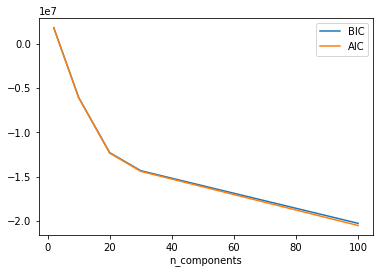

In [43]:
n_components = (2, 10, 20, 30, 100)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(all_benign) for n in n_components]

plt.plot(n_components, [m.bic(all_benign) for m in models], label='BIC')
plt.plot(n_components, [m.aic(all_benign) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');


In [120]:
# Elbow method results show optimal cluster number = 20

In [13]:
print(all_benign.shape)

(292976, 20)


In [14]:
gmm20 = GaussianMixture(n_components=20, random_state=42, covariance_type='full', max_iter = 1000).fit(all_benign)
print("DONE 20")

DONE 20


In [15]:
#all_benign = all_benign.drop([ 'Device', 'Counter'], axis=1)

In [16]:
all_benign['Cluster20'] = gmm20.predict(all_benign)

In [17]:
all_benign.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Cluster20
0,0.244768,0.013891,-0.227410,0.166543,0.439204,0.049217,0.494034,0.045805,0.303775,-0.023956,...,-0.051090,0.008086,-0.006933,0.095386,0.089551,0.144270,0.184848,0.106177,0.097128,10
1,0.449570,0.012148,-0.881305,-0.048516,-0.505958,0.298853,-0.005891,0.725487,0.299820,0.903792,...,0.442254,0.361892,-0.887622,-2.048321,0.606284,-0.547722,-0.576092,0.528249,0.923782,1
2,1.293928,1.086780,0.745623,1.391058,-1.757221,-0.684523,-0.864803,1.401125,1.105831,-0.631978,...,2.394032,-1.585007,-0.687419,2.603145,1.103362,0.817548,-0.105484,-0.143435,-5.189215,17
3,-0.374146,0.953489,0.706444,0.879554,0.080643,0.149182,-0.347978,0.555176,-0.906423,0.441393,...,0.280245,-1.541467,-0.768990,-2.416691,0.399270,-0.932385,-1.187793,0.523111,-0.479323,1
4,0.223781,0.047823,-0.360504,0.039400,-0.107839,0.144846,0.324016,-0.002791,-0.003656,-0.106343,...,-0.075669,0.008156,-0.179342,0.058377,-0.016583,0.004035,-0.076604,0.141653,0.134086,0


In [18]:
labels = labels.reset_index(drop=True)

In [19]:
# adding the device id and cluster labels for kmenas with the optimal number of clusters

#all_benign = pd.DataFrame(all_benign)

# Add the device number back into the dataframe
all_benign['Device'] = labels


# Adding a counter to sum the number of rows in a pivot table
all_benign['Counter'] = 1

all_benign.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Cluster20,Device,Counter
0,0.244768,0.013891,-0.227410,0.166543,0.439204,0.049217,0.494034,0.045805,0.303775,-0.023956,...,-0.006933,0.095386,0.089551,0.144270,0.184848,0.106177,0.097128,10,1,1
1,0.449570,0.012148,-0.881305,-0.048516,-0.505958,0.298853,-0.005891,0.725487,0.299820,0.903792,...,-0.887622,-2.048321,0.606284,-0.547722,-0.576092,0.528249,0.923782,1,5,1
2,1.293928,1.086780,0.745623,1.391058,-1.757221,-0.684523,-0.864803,1.401125,1.105831,-0.631978,...,-0.687419,2.603145,1.103362,0.817548,-0.105484,-0.143435,-5.189215,17,7,1
3,-0.374146,0.953489,0.706444,0.879554,0.080643,0.149182,-0.347978,0.555176,-0.906423,0.441393,...,-0.768990,-2.416691,0.399270,-0.932385,-1.187793,0.523111,-0.479323,1,6,1
4,0.223781,0.047823,-0.360504,0.039400,-0.107839,0.144846,0.324016,-0.002791,-0.003656,-0.106343,...,-0.179342,0.058377,-0.016583,0.004035,-0.076604,0.141653,0.134086,0,1,1


Summary of data points under each device cluster pair
    Device  Cluster20  Counter  Percentage
0        1          0    29063   58.681123
1        1          7      126    0.254407
2        1          8      248    0.500737
3        1         10     7563   15.270459
4        1         11     1772    3.577846
..     ...        ...      ...         ...
73       8         11     3453   14.917055
74       8         12       36    0.155521
75       8         15       10    0.043200
76       8         17       85    0.367202
77       8         19      664    2.868498

[78 rows x 4 columns]


C:\Users\sures\Anaconda3\envs\Tensorflow\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


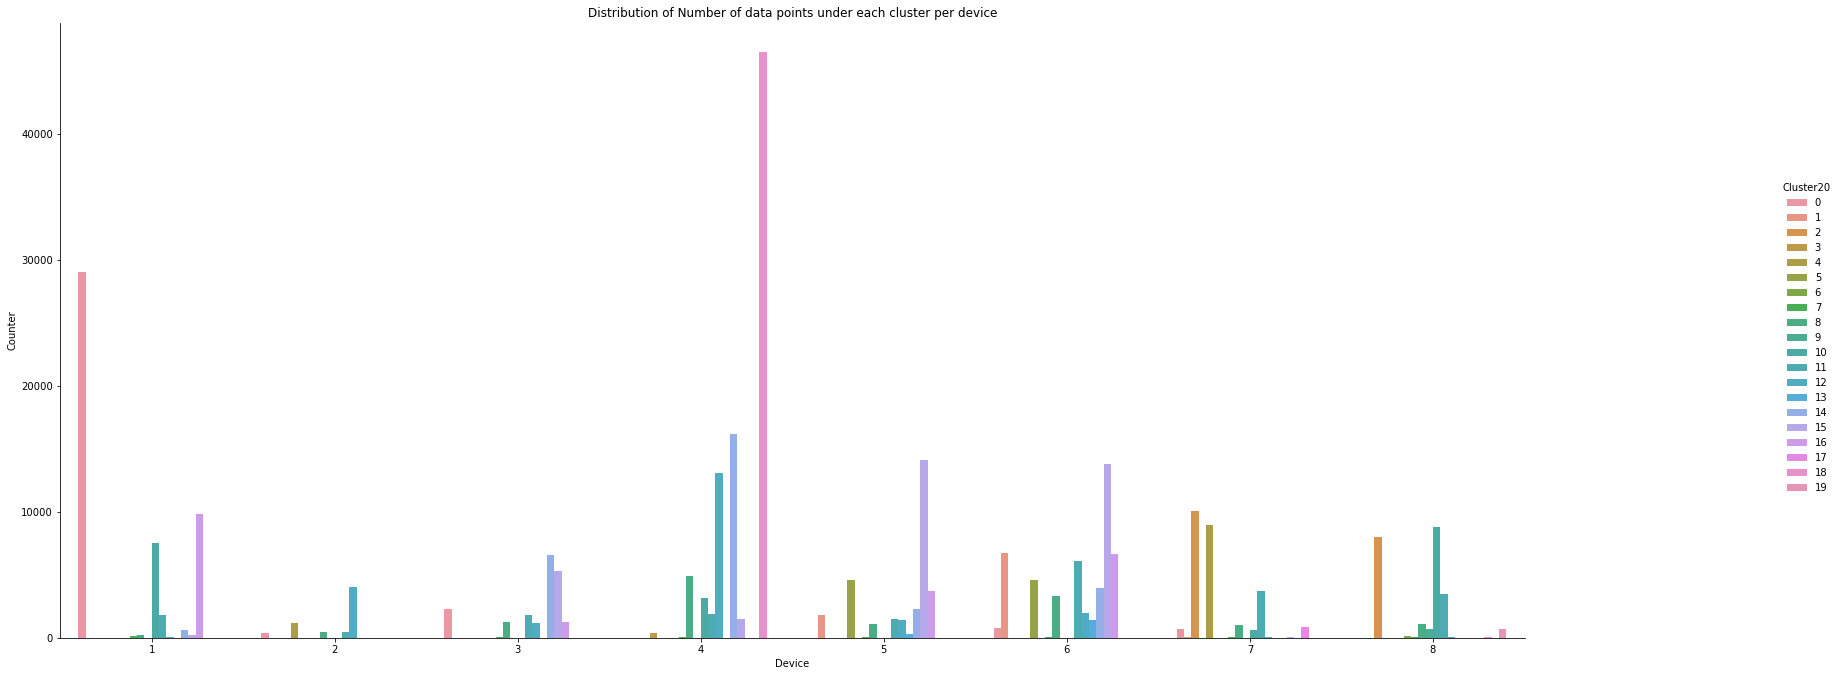

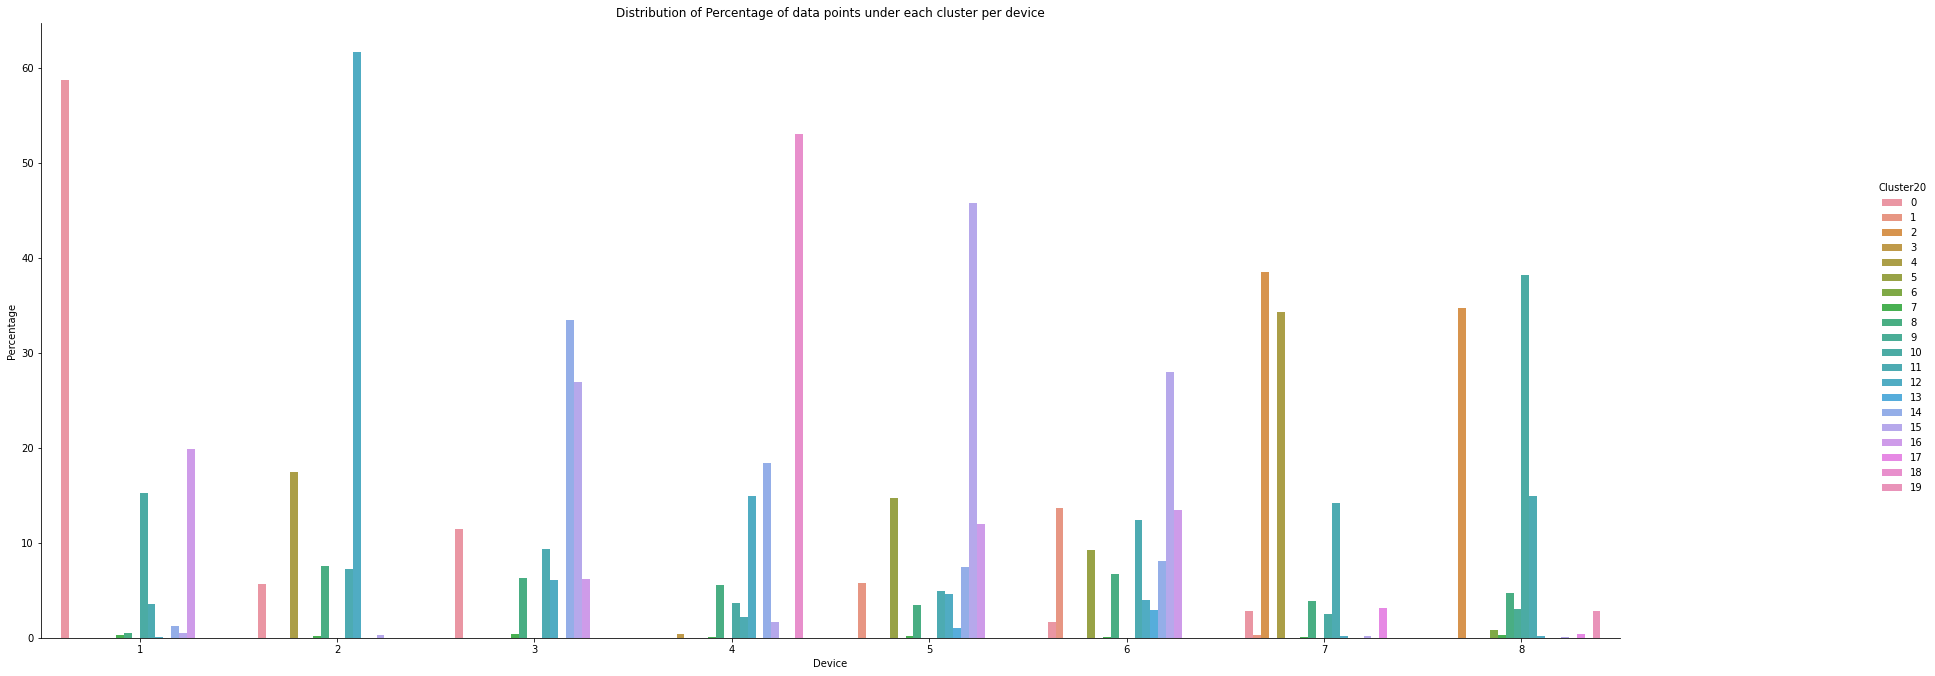

In [20]:

# Create a pivot table to idenitfy the number of data points for each Device and Cluster pair
gmm20_pivot =all_benign.pivot_table(['Counter'] , ['Device', 'Cluster20'], aggfunc='sum').reset_index()

# Idenity the percentage of data points under each Device Cluster pair
gmm20_pivot['Percentage'] = (gmm20_pivot['Counter']/gmm20_pivot.groupby("Device")["Counter"].transform('sum')*100)
print("Summary of data points under each device cluster pair")
print(gmm20_pivot)

# Plot the distrbution of number of data points falling under each cluster for a device
g = sns.factorplot(x='Device', y='Counter', hue='Cluster20', data=gmm20_pivot, kind='bar')
g.fig.set_size_inches(30,10)
plt.title("Distribution of Number of data points under each cluster per device")
plt.show()

# Plot the distrbution of Percentage of data points falling under each cluster for a device
g = sns.factorplot(x='Device', y='Percentage', hue='Cluster20', data=gmm20_pivot, kind='bar')
g.fig.set_size_inches(30,10)
plt.title("Distribution of Percentage of data points under each cluster per device")
plt.show()


In [21]:
# Create a dataframe for percentage distribution into clusters for each device. There are nine rows in the dataframe
# Each row corresponds to the cluster distribution for each device

numclusters = 20
clustergroup = pd.DataFrame(np.zeros((8, numclusters)))
for i in np.arange(1,9,1):
    for j in range(numclusters):
        row = gmm20_pivot.loc[(gmm20_pivot['Device'] == i) & (gmm20_pivot['Cluster20'] == j)]
        if row.empty == False:
            clustergroup.iat[i-1,j] = row['Percentage']
            
print(clustergroup.head())


           0         1    2         3          4          5    6         7  \
0  58.681123  0.000000  0.0  0.000000   0.000000   0.000000  0.0  0.254407   
1   5.712098  0.000000  0.0  0.000000  17.457887   0.000000  0.0  0.137825   
2  11.478500  0.000000  0.0  0.000000   0.000000   0.000000  0.0  0.397391   
3   0.000000  0.000000  0.0  0.450666   0.000000   0.000000  0.0  0.054765   
4   0.000000  5.754836  0.0  0.000000   0.000000  14.750008  0.0  0.174978   

          8    9         10        11         12       13         14  \
0  0.500737  0.0  15.270459  3.577846   0.125184  0.00000   1.217518   
1  7.565084  0.0   0.000000  7.212864  61.607963  0.00000   0.000000   
2  6.246179  0.0   0.015284  9.333605   6.062767  0.00000  33.406358   
3  5.590544  0.0   3.628149  2.163198  14.914202  0.00000  18.443091   
4  3.425035  0.0   0.000000  4.960954   4.636920  1.06283   7.459253   

          15         16   17         18   19  
0   0.494680  19.878046  0.0   0.000000  0.0  
1   

In [22]:
# Identify the device clusters based on similarity of distribution with the aim to group the devices into 3,4 and 5 clusters

kmeans5 = KMeans(n_clusters=5, random_state=0, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 5 groups")
print(kmeans5.labels_)

kmeans4 = KMeans(n_clusters=4, random_state=0, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 4 groups")
print(kmeans4.labels_)

kmeans3 = KMeans(n_clusters=3, random_state=0, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 3 groups")
print(kmeans3.labels_)


# Code to find the cluser distances for five device clusters
centroids = kmeans5.cluster_centers_


# find the distance between the five cluster centroid
distance = spatial.distance.cdist(centroids,centroids)
distance = pd.DataFrame(distance)
print("Distance between clusters")
print(distance.head())

Devices clusters with 5 groups
[4 1 0 3 0 0 2 2]
Devices clusters with 4 groups
[2 3 0 0 0 0 1 1]
Devices clusters with 3 groups
[2 0 0 0 0 0 1 1]
Distance between clusters
           0          1          2          3          4
0   0.000000  71.539635  60.987350  65.012273  69.072911
1  71.539635   0.000000  74.980315  75.605251  87.083873
2  60.987350  74.980315   0.000000  73.837886  74.019576
3  65.012273  75.605251  73.837886   0.000000  85.631580
4  69.072911  87.083873  74.019576  85.631580   0.000000


In [23]:
# Identify the device clusters based on similarity of distribution with the aim to group the devices into 3,4 and 5 clusters

kmeans5 = KMeans(n_clusters=5, random_state=42, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 5 groups")
print(kmeans5.labels_)

kmeans4 = KMeans(n_clusters=4, random_state=42, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 4 groups")
print(kmeans4.labels_)

kmeans3 = KMeans(n_clusters=3, random_state=42, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 3 groups")
print(kmeans3.labels_)


# Code to find the cluser distances for five device clusters
centroids = kmeans5.cluster_centers_


# find the distance between the five cluster centroid
distance = spatial.distance.cdist(centroids,centroids)
distance = pd.DataFrame(distance)
print("Distance between clusters")
print(distance.head())

Devices clusters with 5 groups
[4 3 1 0 1 1 2 2]
Devices clusters with 4 groups
[2 3 1 1 1 1 0 0]
Devices clusters with 3 groups
[2 1 1 1 1 1 0 0]
Distance between clusters
           0          1          2          3          4
0   0.000000  65.012273  73.837886  75.605251  85.631580
1  65.012273   0.000000  60.987350  71.539635  69.072911
2  73.837886  60.987350   0.000000  74.980315  74.019576
3  75.605251  71.539635  74.980315   0.000000  87.083873
4  85.631580  69.072911  74.019576  87.083873   0.000000


In [24]:
clustergroup.shape

(8, 20)

In [25]:
# Identify the device clusters based on similarity of distribution with the aim to group the devices into 3,4 and 5 clusters

GMM5 = GaussianMixture(n_components=5, random_state=42).fit(clustergroup)
clustergroup['Cluster5'] = GMM5.predict(clustergroup)
print("Devices clusters with 5 groups")
print(list(clustergroup.Cluster5))

GMM4 = GaussianMixture(n_components=4, random_state=42).fit(clustergroup)
clustergroup['Cluster4'] = GMM4.predict(clustergroup)
print("Devices clusters with 4 groups")
print(list(clustergroup.Cluster4))

GMM3 = GaussianMixture(n_components=3, random_state=42).fit(clustergroup)
clustergroup['Cluster3'] = GMM3.predict(clustergroup)
print("Devices clusters with 3 groups")
print(list(clustergroup.Cluster3))


Devices clusters with 5 groups
[4, 3, 1, 0, 1, 1, 2, 2]
Devices clusters with 4 groups
[1, 3, 1, 0, 1, 1, 2, 2]
Devices clusters with 3 groups
[1, 1, 1, 0, 1, 1, 2, 2]


In [26]:
print(clustergroup.shape)
clustergroup = clustergroup.drop(['Cluster5', 'Cluster4', 'Cluster3'], axis=1)
print(clustergroup.shape)

print(all_benign.shape)
#all_benign = all_benign.drop(['Cluster20', 'Device', 'Counter'], axis=1)
all_benign = all_benign.drop(['Device', 'Counter'], axis=1)
print(all_benign.shape)


(8, 23)
(8, 20)
(292976, 23)
(292976, 21)
